In [15]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import copy
import matplotlib.pyplot as plt
import os.path
from os import path

%matplotlib inline

In [2]:
def CAGR(df):
    "Calculates Cumulative Annual Growth Rate of a data frame. Expects mon_ret column containing percent change of the adjusted close price of a stock price"
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(df):
    "Calculates annualized volatility of a data frame. Expects mon_ret column containing percent change of the adjusted close price of a stock price"
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(df, rf):
    "Calculates Sharpe Ratio of a data series; rf is the risk free rate. Expects mon_ret column containing percent change of the adjusted close price of a stock price"
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(df):
    "Calculate max drawdown of a data frame. Expects mon_ret column containing percent change of the adjusted close price of a stock price"
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

### Get historical data for DJ

In [3]:
tickers = ["MMM","AXP","T","BA","CAT","CVX","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UTX","UNH","VZ","V","WMT","DIS"]

# THIS WOULD WORK ONLY DURING BUILLISH MARKET
# tickers = ['XLV', 'XLK', 'XLI', 'XLP', 'XLE', 'XLU', 'XLB', 'XLY', 'XLF', 'IYR']

ohlc_mon = {}
attempt = 0
drop = []

if not path.exists('data/returns.csv'):
    while len(tickers) != 0 and attempt <= 5:
        tickers = [j for j in tickers if j not in drop] # removing stocks whose data has been extracted from the ticker list
        for i in range(len(tickers)):
            try:
                ohlc_mon[tickers[i]] = pdr.get_data_yahoo(tickers[i],datetime.date.today()-datetime.timedelta(1900),datetime.date.today(),interval='m')
                ohlc_mon[tickers[i]].dropna(inplace = True)
                drop.append(tickers[i])       
            except:
                print(tickers[i]," :failed to fetch data...retrying")
                continue
        attempt+=1

    # redefine tickers variable after removing any tickers with corrupted data
    tickers = ohlc_mon.keys()

### Backtesting

In [16]:
if not path.exists('data/returns.csv'):
    ohlc_dict = copy.deepcopy(ohlc_mon)
    return_df = pd.DataFrame()
    for ticker in tickers:
        print("calculating monthly return for ",ticker)
        ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
        return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
else:
    print('Reading previously obtained data')
    return_df = pd.read_csv('data/returns.csv')

Reading previously obtained data


In [5]:
# function to calculate portfolio return iteratively
def pflio(df,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    
    portfolio = []
    monthly_ret = [0]
    
    for i in range(1,len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        # print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df


In [6]:

#calculating overall strategy's KPIs
print("CAGR: " + str(CAGR(pflio(return_df,6,3))))
print("Sharpe: " + str(sharpe(pflio(return_df,6,3),0.025)))
print("Max DD: " + str(max_dd(pflio(return_df,6,3))))

CAGR: 0.1533246100740704
Sharpe: 0.9875667351541305
Max DD: 0.07078267467660831


In [17]:
start_date = datetime.date.today()-datetime.timedelta(1900)
end_date = datetime.date.today()

print("Looking at time period " + str(start_date) + " to " + str(end_date))

#calculating KPIs for Index buy and hold strategy over the same period
if not path.exists('data/DJI.csv'):
    DJI = pdr.get_data_yahoo("^DJI", start_date, end_date, interval='m')
    DJI["mon_ret"] = DJI["Adj Close"].pct_change()
else:
    DJI = pd.read_csv('data/DJI.csv')

print("CAGR  : " + str(CAGR(DJI)))
print("Sharpe: " + str(sharpe(DJI,0.025)))
print("Max DD: " + str(max_dd(DJI)))

Looking at time period 2014-07-18 to 2019-09-30
CAGR  : 0.09067766421893886
Sharpe: 0.5486461944248292
Max DD: 0.11833142572834397


In [18]:
if not path.exists('data/SPX.csv'):
    SPX = pdr.get_data_yahoo("^GSPC", start_date, end_date, interval='m')
    SPX["mon_ret"] = SPX["Adj Close"].pct_change()
else:
    SPX = pd.read_csv('data/SPX.csv')

print("CAGR  : " + str(CAGR(SPX)))
print("Sharpe: " + str(sharpe(SPX, 0.025)))
print("Max DD: " + str(max_dd(SPX)))

CAGR  : 0.07856925044462737
Sharpe: 0.45466530480256884
Max DD: 0.13971608780476522


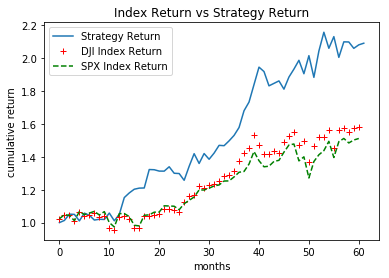

In [9]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"][2:].reset_index(drop=True)).cumprod(), 'r+')
plt.plot((1+SPX["mon_ret"][2:].reset_index(drop=True)).cumprod(), 'g--')
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","DJI Index Return", "SPX Index Return"])

In [13]:
return_df.to_csv('data/returns.csv')
DJI.to_csv('data/DJI.csv')
SPX.to_csv('data/SPX.csv')